In [3]:
# Load & query database
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# do t-tests
from scipy import stats
import sys  
sys.path.insert(0, '../../stats_probability/dsc-website-ab-testing-lab-online-ds-sp-000/')
import flatiron_stats as fstats

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [15]:
#calculate effect sizes (diff in price w.r.t. sample size ? ) and find p values?
from statsmodels.stats.power import TTestIndPower, TTestPower

## 1. Querying Data & Exploratory Data Analysis

In [16]:
query = """SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"""

In [17]:
query = """SELECT * FROM 'OrderDetail';"""

In [160]:
cur.execute(query)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [161]:
df.groupby('Discount').Quantity.describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [162]:
df = df[~df.Discount.isin([0.01, 0.02, 0.03, 0.04, 0.06])]

In [163]:
discount_df = df[df.Discount != 0]
fullprice_df = df[df.Discount == 0]

In [164]:
product_ids = list(discount_df.ProductId.unique())
product_ids.sort()

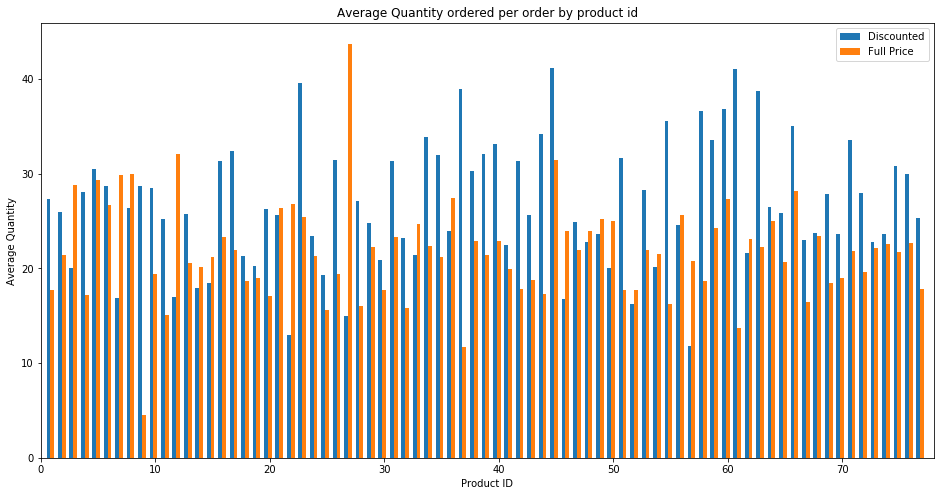

In [165]:
plt.figure(figsize=(16,8))

width = np.min(np.diff(product_ids))/3
plt.bar(product_ids - width, discount_df.groupby('ProductId').Quantity.mean(), width, label='Discounted')
plt.bar(product_ids, fullprice_df.groupby('ProductId').Quantity.mean(), width, label='Full Price')
plt.xlim(0, max(product_ids)+1)
plt.legend()
plt.title("Average Quantity ordered per order by product id")
plt.xlabel('Product ID')
plt.ylabel("Average Quantity")
plt.show();

### Mean and SD of discount vs. full price orders

In [167]:
print("Mean quantity in non discount orders {} vs. discounted: {}".format(round(fullprice_df.Quantity.mean(), 1)
                                                                         ,round(discount_df.Quantity.mean(),1)))
print("SD non discount {} vs. discounted {}".format(round(np.std(fullprice_df.Quantity),1 ),
                                                    round(np.std(discount_df.Quantity),1 ) ))

Mean quantity in non discount orders 21.7 vs. discounted: 27.4
SD non discount 17.5 vs. discounted 20.7


In [168]:
discount_df.Quantity.sum(), fullprice_df.Quantity.sum()

(22704, 28599)

In [57]:
import warnings
warnings.filterwarnings("ignore")

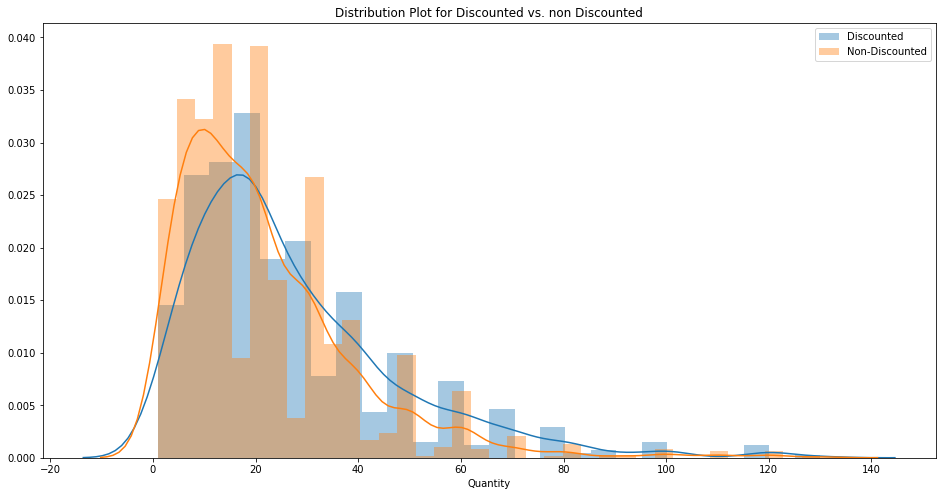

In [134]:
plt.figure(figsize=(16,8))
sns.distplot(discount_df.Quantity, label='Discounted')
sns.distplot(fullprice_df.Quantity, label='Non-Discounted').set_title("Distribution Plot for Discounted vs. non Discounted")
plt.legend()
plt.show();

## TO DO - Skew and Kurtosis

## KS Test to test for normal distribution

**Hypothesis**: There is no difference between sample & hypothetical normal distribution.
Acceptance Criteria: If the calculated value is less than the critical value, accept the null hypothesis.
Rejection Criteria: If the calculated value is greater than the critical value, reject the null hypothesis

In [25]:
#KS test to see if the data comes from the same distributions
print(stats.kstest(discount_df.Quantity, 'norm', args=(discount_df.Quantity.mean(), discount_df.Quantity.std()))) 
print(stats.kstest(fullprice_df.Quantity, 'norm',
                   args=(fullprice_df.Quantity.mean(), fullprice_df.Quantity.std() )))
print(stats.ks_2samp(fullprice_df.Quantity,discount_df.Quantity))

KstestResult(statistic=0.1526687391490758, pvalue=0.0)
KstestResult(statistic=0.1571445192364258, pvalue=0.0)
Ks_2sampResult(statistic=0.12135050550629461, pvalue=4.763897379538179e-07)


The p-values are 0. meaning that we can reject the null hypothesis that the ditribution is normal TO DO, we should use Welch's T-test which doe not assume equal variances .. TODO Ask but they vary w.r.t. each other

## Welch's T-test for difference between the groups 

**Question**: is there a difference in quantity of items ordered when the item is discounted vs. full price?
**H0**: There is no difference in quantity of items ordered when there is a discount vs. full price.
**H1**: There is an increase in quantity of items ordered when there is a discount.

In [147]:
#when equal_var=False, welch's t test is used
t, p = stats.ttest_ind(discount_df.Quantity, fullprice_df.Quantity, equal_var=False) 

In [157]:
if p < 0.025:
    print("Reject null hypothesis, there is an increase in quantity ordered when there is a discount.")
else:
    print("There is an incrase in the quantity ordered when there is a discount.")
print("T-stat: {}, p-value: {}".format(round(t,2), p))

Reject null hypothesis, there is an increase in quantity ordered when there is a discount.
T-stat: 6.51, p-value: 1.0051255540843165e-10


### ANOVA to test differnences across discount amounts

Hypothesis: Is amount of discount significant in predicting quantity of the item per order

In [138]:
# Your code here
formula = 'Quantity ~ Discount'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df          F        PR(>F)
Discount   12884.989179     1.0  36.191587  2.095888e-09
Residual  766514.647015  2153.0        NaN           NaN


In [139]:
# Your code here
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


### Unit Price & Discount amount
Hypothesis: Does price affect & discount have an effect on total widgets purchased? 

In [29]:
formula = 'Quantity ~ C(Discount) + UnitPrice'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21255.528525    10.0  6.008507  4.771280e-09
UnitPrice        39.418992     1.0  0.111429  7.385552e-01
Residual     758101.813599  2143.0       NaN           NaN


In [169]:
df_ols = pd.get_dummies(df, columns=['Discount'], prefix=["discount"])
X = df_ols.drop(['Id', 'OrderId', 'ProductId'], axis=1)
new_columns = []
for x in X.columns:
    x = x.replace(".", '')
    new_columns.append(x)
X.columns = new_columns
X.head()

,UnitPrice,Quantity,discount_00,discount_005,discount_01,discount_015,discount_02,discount_025
0,14.0,12,1,0,0,0,0,0
1,9.8,10,1,0,0,0,0,0
2,34.8,5,1,0,0,0,0,0
3,18.6,9,1,0,0,0,0,0
4,42.4,40,1,0,0,0,0,0


In [170]:
outcome = 'Quantity'
predictors = X.drop(columns=['Quantity']).columns
f = '+'.join(predictors)
formula = outcome + '~' + f
stats_model = ols(formula=formula, data=X).fit()

In [171]:
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.181
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           9.07e-09
Time:                        15:51:28   Log-Likelihood:                -9344.4
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2140   BIC:                         1.874e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.5566      0.564     40.024      0.000      21.451      23.662
UnitPrice        0.0046      0.014      0.334      0.738      -0.022       0.031
discount_00     -0.9605      0.647     -1.484      0.138      -2.230       0.309
discount_005     5.3140      1.267      4.194      0.000       2.829       7.799
discount_01      2.5658      1.299      1.975      0.048       0.018       5.114
discount_015     5.7210      1.355      4.222      0.000       3.064       8.378
discount_02      4.3611      1.340      3.254      0.001       1.733       6.989
discount_025     5.5552      1.369      4.058      0.000       2.871       8.240
==============================================================================
Omnibus:                      784.957   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3073.377
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                       7.671   Cond. No.                     6.14e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Visualize interactions
#https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

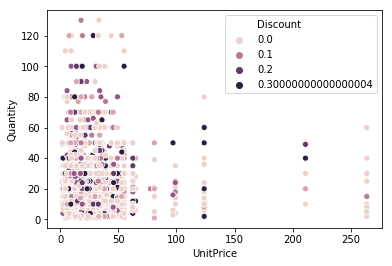

In [51]:
sns.scatterplot(x=df['UnitPrice'],y= df['Quantity'], hue=df['Discount'])

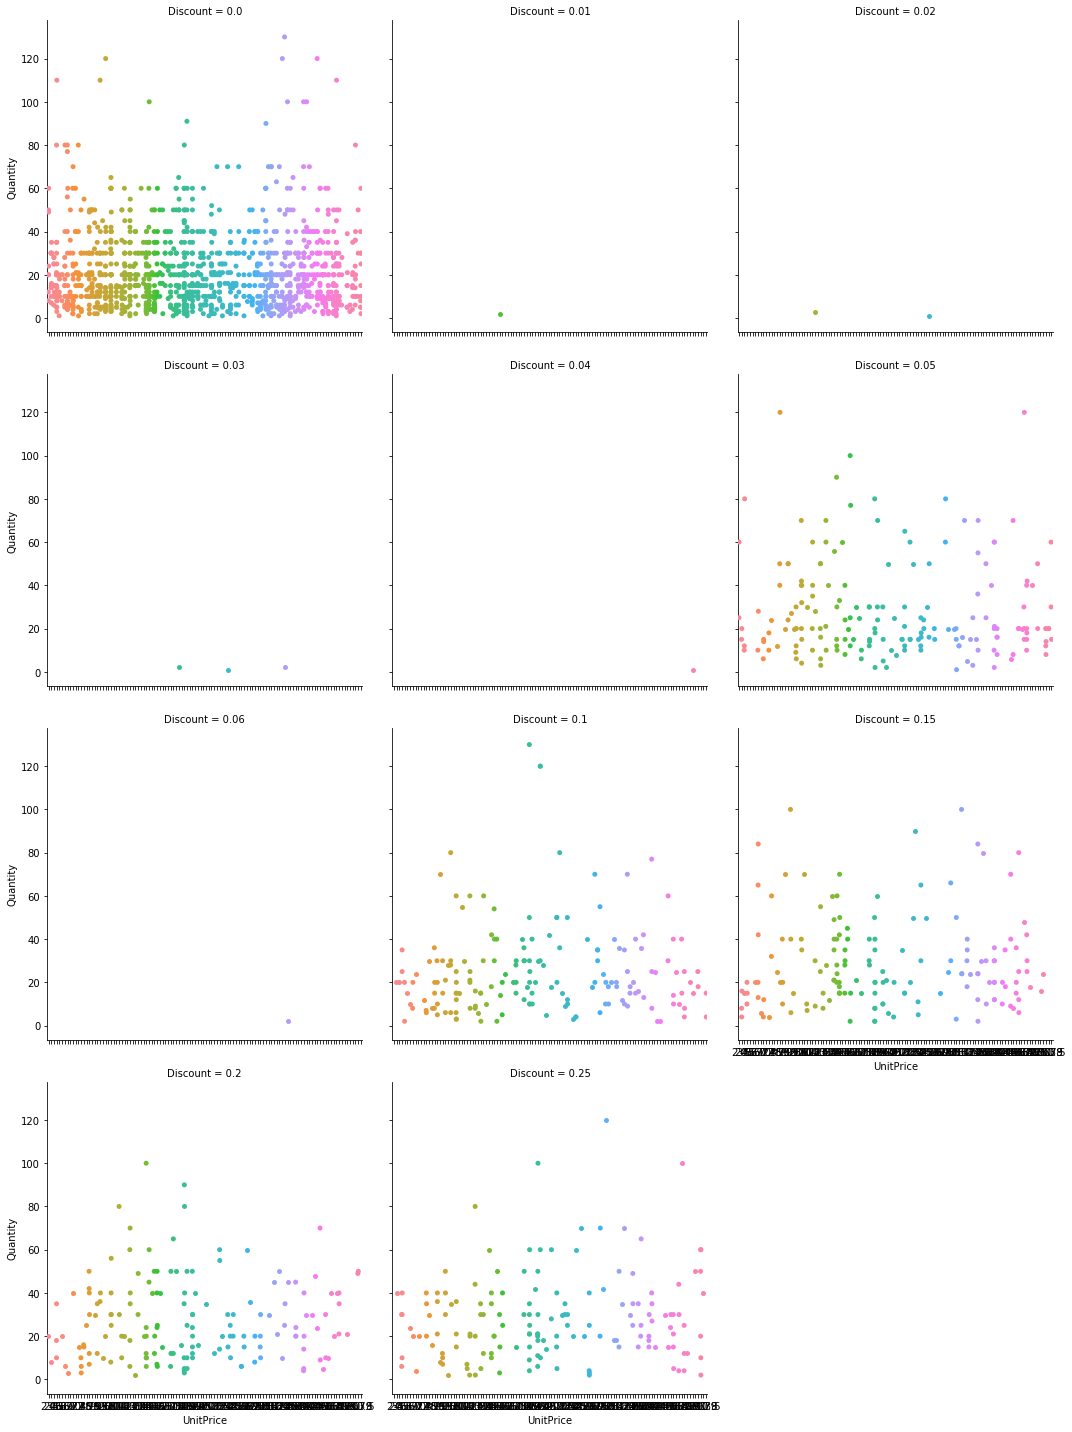

In [52]:
g = sns.catplot(data=df, x="UnitPrice", y='Quantity', col='Discount', col_wrap=3)

In [ ]:
g = sns.pairplot(df[["mpg", "horsepower", "weight", "origin"]], hue="origin", diag_kind="hist")

<Figure size 1440x1080 with 0 Axes>

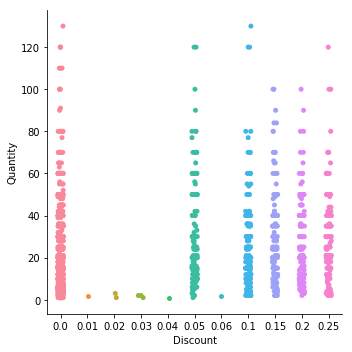

In [42]:
plt.figure(figsize=(20,15))
sns.catplot(data=df, x="Discount", y='Quantity');

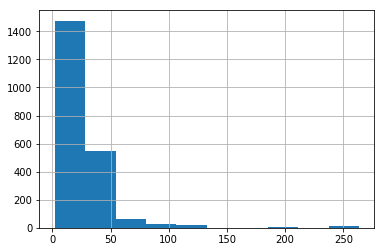

In [43]:
df['UnitPrice'].hist()

Are some items just things you buy lots of (like paper clips) and discount doesn't really matter vs. other things that are costly and you only need a few

In [49]:
axs.reshape(-1)
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c276386d8>,
      dtype=object)